## 1. Introduction, Motivation and Problem Statement
Image segmentation is a key technology in computer vision and is important in applications as diverse as medical imaging, self-driving cars, and satellite imagery. It involves decomposing images into meaningful regions, enhancing object detection and recognition capabilities, which is critical for progress in these fields.

In the field of autonomous driving, the importance of image segmentation technology is increasingly recognized. Precise segmentation of objects and road elements in images is crucial for the safety of autonomous vehicles.

This project aims to evaluate three leading image segmentation methods - U-net, Segnet and deeplabv3 - using a comprehensive dataset to classify images captured by cameras of vehicles during autonomous driving into 27 categories. The goal is to gain insights into the performance of these methods and how they can improve autonomous driving systems.

The main goal of this study is to investigate the effectiveness of different image segmentation techniques (especially U-net, Segnet, and deeplabv3) in autonomous driving scenarios. Accurate image segmentation is crucial to enhance the perception capabilities of autonomous vehicles, thereby ensuring their safe and efficient navigation in complex environments. This research aims to improve current methods by evaluating the ability of these advanced models to identify and segment key elements of autonomous driving, such as lanes, vehicles, pedestrians, and traffic signs.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
from torchvision.transforms.functional import to_pil_image
import cv2
from torchvision import models

## 2. Data source or reinforcement learning task
The IDD 20K dataset is a curated collection of images for autonomous driving research, containing a variety of road scenes, traffic signs, pedestrians, and vehicles.


The dataset, which initially contained 5,966 training images and 1,016 validation images, was enhanced through preprocessing and data augmentation to include approximately 3,000 additional images, ensuring a broad representation of the scenarios in which the image segmentation model was trained.


Strict quality control measures are employed to maintain data relevance and accuracy. The dataset is publicly available for download on Kaggle: https://www.kaggle.com/datasets/abhishekprajapat/idd-20k/data

In [2]:
# Define the dataset class specific to DeepLabV3, segement the image to 27 classes. 
input_height = 512
input_width = 512
n_classes = 27

class deeplabv3(Dataset):
    # Initialize the dataset
    def __init__(self, txt_file, image_folder, label_folder, transform=None, label_transform=None):
         # Read the file paths from the text file
        with open(txt_file, "r") as f:
            self.lines = f.readlines()
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.label_transform = label_transform if label_transform is not None else transforms.Compose([
            transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST),
        ])

    # Return the length of the dataset
    def __len__(self):
        return len(self.lines)

    # Get a specific item (image-label pair) from the dataset
    def __getitem__(self, idx):
        img_name, label_name = self.lines[idx].strip().split(';')
        img = Image.open(os.path.join(self.image_folder, img_name))
        label = Image.open(os.path.join(self.label_folder, label_name))

        # Apply transformations to the image and label
        if self.transform:
            img = self.transform(img)
        if self.label_transform:
            label = self.label_transform(label)
        # Convert label to a numpy array and handle ignore indices
        label = np.array(label, dtype=np.int32)
        label[label == 255] = 26
        label = torch.from_numpy(label).long()
        return img, label

# Define image transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((input_height, input_width)), 
    transforms.ToTensor(), 
])

test_transform = transforms.Compose([
    transforms.Resize((input_height, input_width)),
    transforms.ToTensor(),  
])

label_transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST)
])


## 3. Exploratory Analysis of Data

The dataset used in our segmentation model has a resolution of 512x512 pixels and contains 27 different categories of various elements commonly found in autonomous driving scenarios. Additionally, there is a special consideration in our dataset where a pixel value of 255 represents "unlabeled/not in the region of interest (ROI)" data. To prepare the segmentation model for training, we performed several preprocessing steps. Our dataset adds noise and complexity to simulate realistic and challenging scenarios encountered in autonomous driving.


During preprocessing, we handle the special case of pixel value 255 by treating it as a separate class and using the ignore_index parameter set to 26 in the nn.CrossEntropyLoss function. This approach allows our model to effectively ignore “unlabeled/ROI” pixels during loss calculation, preventing them from adversely affecting the training process.
Preprocessing steps applied to the image include resizing to the required input size and converting the image to a PyTorch tensor. We also applied a similar resizing transformation to the labels, ensuring that the pixel value 255 was reassigned to category 26, thus maintaining data consistency.


The dataset is loaded using a custom DeepLabV3 class that applies these transformations to images and labels. The image is resized according to the specified input_height and input_width before being converted to a tensor. The labels go through a resizing step to ensure they match the output dimensions expected by the network.
The training loop involves the standard procedure of zeroing the gradients, performing a forward pass, calculating the loss, and then updating the model weights via backpropagation. We track run loss and accuracy, regularly outputting these metrics to monitor model performance.


Overall, the selected preprocessing techniques aim to enhance the model's robustness to noise and complex scenarios, which are common in real-world autonomous driving applications. By treating “unlabeled/ROI” data as a separate class for loss calculations, we aim to improve the model’s accuracy in predicting related classes.

In [3]:
# Setting the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the training dataset
train_dataset = deeplabv3(
    txt_file=r"E:\UNSW t3\9444\assignment2\train.txt",
    image_folder=r"E:\UNSW t3\9444\assignment2\dataset\idd20k_final\train\images",
    label_folder=r"E:\UNSW t3\9444\assignment2\dataset\idd20k_final\train\labels",
    transform=train_transform,
    label_transform=label_transform
)

# DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)

# Modify DeepLabV3 model for the specific number of classes
model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
model.classifier[4] = nn.Conv2d(256, 27, kernel_size=(1,1), stride=(1,1))  

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=26)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Setup for saving model weights
weights_folder = './logs/'
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
best_accuracy = 0.0
weight_path = 'logs/best_model.pth'


d:\app\Ano\envs\DeepLearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\app\Ano\envs\DeepLearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 4. Models and/or methods:
In this project, the DeeplabV3 model was chosen for its efficacy in semantic segmentation of images, an important component of autonomous driving systems. This model was developed by Google's research team and mainly uses Atrous Convolution, Atrous Spatial Pyramid Pooling and other methods to improve the model's ability to understand and capture context. DeepLabv3 is often used in conjunction with pre-trained deep neural networks (such as ResNet) to extract image features and thereby improve the performance of segmentation. Due to its high accuracy and flexibility, DeepLabv3 is widely used in fields such as street scene understanding and medical image analysis.

During the implementation process, we accelerated the training by transferring the model to the GPU using CUDA to enhance computing performance, thereby achieving faster model training and iteration. Model optimization is handled by the Adam optimizer, which is known for its efficiency in achieving convergence by dynamically adjusting the learning rate, and the model will converge faster early compared to other optimizers. A batch size of 4 was chosen to optimize GPU memory usage while allowing adequate gradient estimation during backpropagation. We set the initial learning rate to 1e-3 and the training epoch to 10.

Pre-trained weights are used in this model, a choice made to contrast models with manually set weights.

Apart from the basic Deeplabv3 architecture, the entire project is an original work. This includes data preprocessing, dataset preparation, experimental design, training process, and subsequent analysis of results. By designing the system from the ground up, we have complete control over the variables and ensure that the results are a direct result of our method choices and data characteristics.

Methodological decisions (from the choice of model to the details of implementation) are made with careful consideration of the project goals, the nature of the data, and the required computational efficiency.

In [4]:
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    for i, data in enumerate(tqdm(train_loader), 0):
        # Load inputs and labels to the device
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)['out']
        # Resize outputs for loss calculation
        outputs = F.interpolate(outputs, size=(64, 64), mode='bilinear', align_corners=False)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.numel()

    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_accuracy = 100. * correct / total
    print('Epoch [%d] finished, time: %.3fs, loss: %.3f, accuracy: %.3f' %
          (epoch + 1, epoch_time, running_loss / (i + 1), epoch_accuracy))

    # Save model at certain epochs
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), os.path.join(weights_folder, 'epoch_%d.pth' % (epoch + 1)))

    # Save the best model
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model.state_dict(), os.path.join(weights_folder, 'best_model.pth'))

100%|██████████| 1492/1492 [28:20<00:00,  1.14s/it]


Epoch [1] finished, time: 1700.314s, loss: 0.734, accuracy: 77.504


100%|██████████| 1492/1492 [27:16<00:00,  1.10s/it]


Epoch [2] finished, time: 1636.755s, loss: 0.515, accuracy: 83.270


100%|██████████| 1492/1492 [27:36<00:00,  1.11s/it]


Epoch [3] finished, time: 1656.200s, loss: 0.451, accuracy: 85.164


100%|██████████| 1492/1492 [27:42<00:00,  1.11s/it]


Epoch [4] finished, time: 1662.243s, loss: 0.408, accuracy: 86.454


100%|██████████| 1492/1492 [26:44<00:00,  1.08s/it]


Epoch [5] finished, time: 1604.802s, loss: 0.381, accuracy: 87.247


100%|██████████| 1492/1492 [24:50<00:00,  1.00it/s]


Epoch [6] finished, time: 1490.209s, loss: 0.358, accuracy: 87.918


100%|██████████| 1492/1492 [26:03<00:00,  1.05s/it]


Epoch [7] finished, time: 1563.402s, loss: 0.331, accuracy: 88.798


100%|██████████| 1492/1492 [27:20<00:00,  1.10s/it]


Epoch [8] finished, time: 1640.191s, loss: 0.312, accuracy: 89.322


100%|██████████| 1492/1492 [27:26<00:00,  1.10s/it]


Epoch [9] finished, time: 1646.559s, loss: 0.293, accuracy: 89.971


100%|██████████| 1492/1492 [27:21<00:00,  1.10s/it]

Epoch [10] finished, time: 1641.393s, loss: 0.276, accuracy: 90.526


In [5]:
# Define a color mapping for different classes
COLOR_MAP = {i: np.array([random.randint(0, 255) for _ in range(3)]) for i in range(26)}
COLOR_MAP[26] = np.array([0, 0, 0])  # Color for the ignore index

# Function to decode segmentation masks to color images
def decode_segmentation_masks(mask, colormap, n_classes):
    output_height, output_width = mask.shape
    color_mask = np.zeros((output_height, output_width, 3), dtype=np.uint8)
    for label_id, color in colormap.items():
        color_mask[mask == label_id] = color

    return color_mask

# Function to overlay color mask on the original image
def overlay_mask(image, color_mask, alpha=0.5):
    """ Return the image with an overlaid mask. """
    color_mask = cv2.resize(color_mask, (image.shape[1], image.shape[0]))

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

# Initialize variables for visualization
visualization_count = 0
visualization_limit = 5

In [6]:
# Initialize the test dataset
test_dataset = deeplabv3(
    txt_file=r"E:\UNSW t3\9444\assignment2\test.txt",
    image_folder=r"E:\UNSW t3\9444\assignment2\dataset\idd20k_final\valid\images",
    label_folder=r"E:\UNSW t3\9444\assignment2\dataset\idd20k_final\valid\labels",
    transform=test_transform,
    label_transform=label_transform
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, pin_memory=True)

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)['out']
        outputs = F.interpolate(outputs, size=(64, 64), mode='bilinear', align_corners=False) 
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.numel()
        all_predicted.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())
        predicted_np = predicted.cpu().numpy()

100%|██████████| 254/254 [01:56<00:00,  2.18it/s]


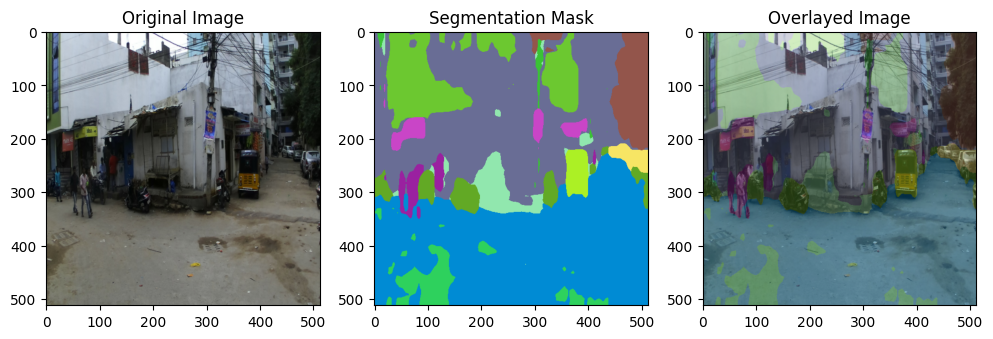

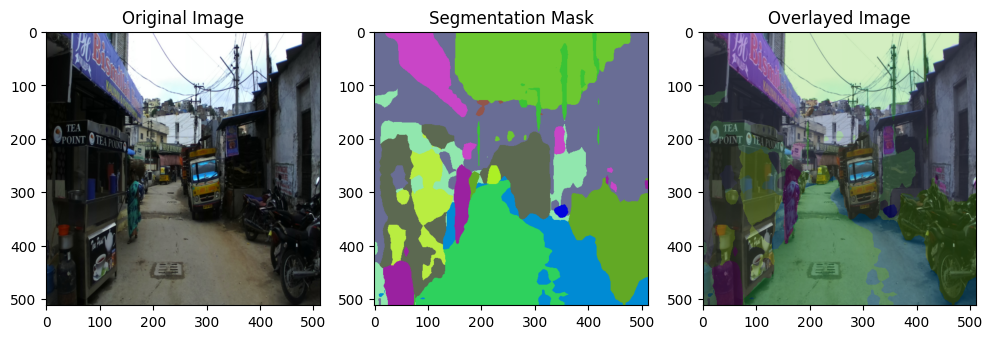

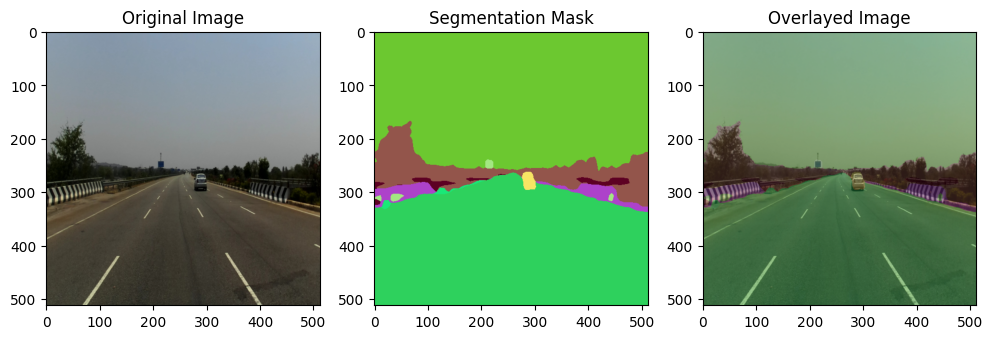

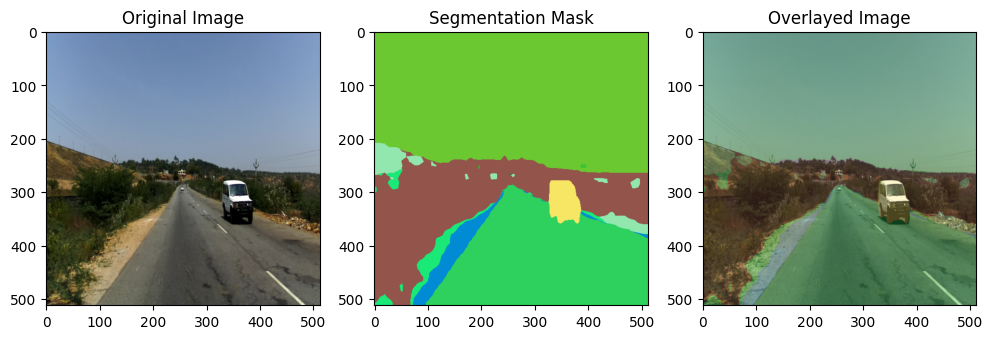

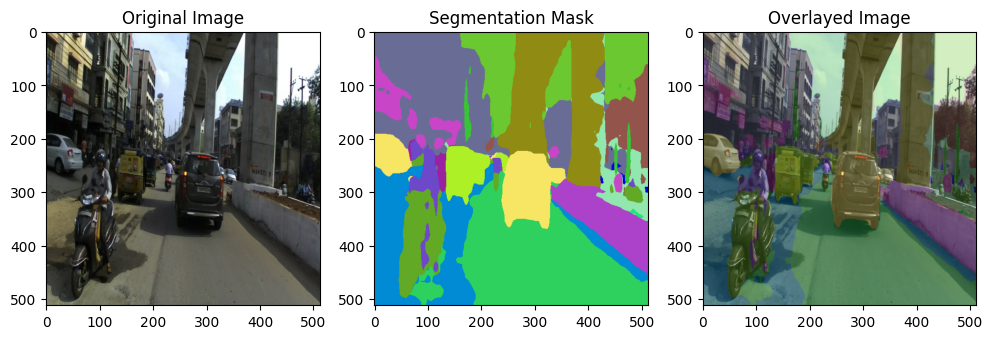

In [7]:
with torch.no_grad():
    for data in test_loader:
        if visualization_count >= 5:
            break
        images, labels = data
        images = images.to(device)
        outputs = model(images)['out']
        _, predicted = torch.max(outputs, 1)

        for img, pred in zip(images, predicted):
            if visualization_count >= 5:
                break

            img_pil = to_pil_image(img.cpu())
            pred_np = pred.cpu().numpy()

            color_mask = decode_segmentation_masks(pred_np, COLOR_MAP, n_classes)
            overlayed_img = overlay_mask(np.array(img_pil), color_mask, alpha=0.7)

            # Display the original image, segmentation mask, and overlayed image
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img_pil)
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(color_mask)
            plt.title('Segmentation Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(overlayed_img)
            plt.title('Overlayed Image')
            plt.show()
            visualization_count += 1

In [8]:
valid_labels = np.array(all_labels)
valid_predictions = np.array(all_predicted)

# Calculate precision, recall, and F1 score
precision = precision_score(valid_labels, valid_predictions, average='macro', zero_division=1)
recall = recall_score(valid_labels, valid_predictions, average='macro', zero_division=1)
f1 = f1_score(valid_labels, valid_predictions, average='macro')

# Calculate and print loss and accuracy
test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / total
print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.0f}%)')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
classification_rep = classification_report(valid_labels, valid_predictions, zero_division=1)
print("Classification Report:")
print(classification_rep)


Test set: Average loss: 0.0985, Accuracy: 3619323/4161536 (87%)
Precision: 0.7547, Recall: 0.6360, F1 Score: 0.6514
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95   1045043
           1       0.73      0.77      0.75    253891
           2       0.69      0.69      0.69     13090
           3       0.57      0.67      0.61     60359
           4       0.76      0.76      0.76     40470
           5       0.75      0.74      0.74     27833
           6       0.74      0.88      0.80     54774
           7       0.42      0.27      0.33      1481
           8       0.86      0.90      0.88     59337
           9       0.91      0.88      0.90     93971
          10       0.65      0.85      0.74     47646
          11       0.93      0.70      0.80     14775
          12       0.61      0.32      0.42     16388
          13       0.89      0.81      0.85     59295
          14       0.67      0.46      0.54     5

## 5. Result
After ten rounds of rigorous training, the Accuracy of the DeepLabV3 training set reached an astonishing 90.5%. When evaluated on the validation set, the accuracy stabilized at 87%. The precision index is 0.754, the recall rate is 0.636, and the F1 score is 0.651.

In addition to printing these indicators, we also visualized five segmented result pictures. By assigning different colors to each segmented object, it is easier to observe the segmentation results. Judging from the results, the segmentation effect is quite good. This is a success. Segmentation model.

The reason why the model performs so well is because it uses pre-trained weights, and after adjusting the optimizer and loss function, the desired segmentation results are obtained.

## 6. Discussion
In summary, the model achieves very good segmentation on this dataset. The reason why it can achieve such good results is that the Deeplabv3 model itself is the third generation of the Deeplab series of models and is a very mature segmentation model. Secondly, pre-trained weights are used on the model, so that the model produces good segmentation.

Then the model also has problems, mainly reflected in the very slow training speed. This is a complex model, and due to insufficient device performance, the batch size has to be set to 4. Setting the batch size too large will directly cause GPU memory overflow. Each round of training lasts about 28 minutes, and 10 epochs take about 5 hours.

Future optimization work is mainly to solve equipment problems so that the model can be trained with a larger batch size and run more epochs, so that the model Accuracy should be improved. And you can judge how many epochs of training are most appropriate by drawing the change trend table of loss and accuracy, and then use early stopping technology to achieve the best segmentation effect.